# This notebook is to explore adding cdc embedding features to AMR and determine its effect in performance

In [1]:
import sys
sys.path.append("../..")
import pandas as pd
import numpy as np
from src.models.baseline_ML_functions import common_name_to_genus_speices, get_max_accuracy
from src.models.NN_functions import *
from src.preprocessing.load_data import toxicity_data2
from harness.th_model_instances.hamed_models.random_forest_classification import random_forest_classification
from harness.th_model_instances.hamed_models.rocklin_models import logistic_classifier
from harness.th_model_instances.perovskite_models.xgboost import gradient_boosted_tree
from harness.th_model_instances.hamed_models.navie_bayes import gaussian_naive_bayes_classification
from models.ML_functions import *
from preprocessing.load_data import get_mapping_df
strain_mapping_data = get_mapping_df()
from sys import platform 
prefix = 'G:' if platform == 'win32' else '/Volumes/GoogleDrive'
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
old_ivv = pd.read_csv(prefix+'old_toxicity_ivv.csv')
new_ivv = toxicity_data2(prefix+'processed_PI_12_22_2020.csv', 
                         prefix+'processed_hoechst_12_22_2020.csv',
                         add_time = True)
joined_toxicity = pd.concat([old_ivv, new_ivv]).reset_index(drop = True)

In [8]:
name_mapping = common_name_to_genus_speices()
joined_toxicity['genus_species'] = joined_toxicity['Common Name'].map(name_mapping)

In [9]:
post_train_mean = pd.read_csv(prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/cdc_post_train_emb2.csv', index_col = 0)
tox_w_cdc_emb = pd.merge(joined_toxicity, post_train_mean, left_on = 'genus_species', right_index = True)

# Test using only the toxicity features

In [10]:
tox_w_cdc_emb['index_col'] = range(len(tox_w_cdc_emb))
feature_cols1 = ['Time', 'DAPI', 'Hoechst']
th_path = prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/toxicity/tox_w_cdc_Apr16'

In [31]:
run_ml(tox_w_cdc_emb, 'tox_no_cdc1',feature_cols_to_use=feature_cols1, 
       models_to_test = [logistic_classifier, gaussian_naive_bayes_classification, random_forest_classification, gradient_boosted_tree],
       output_dir = th_path, repeat = 10, 
       feature_cols_to_normalize=feature_cols1, sparse_cols_to_use=None, percents = [0.3,0.4,0.5,0.6,0.7])


----------------------------------------------------------------------------------------------------
Starting run of model logistic_classifier at time 15:41:30
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.01 seconds
Testing time was: 0.01 seconds
Run finished at 15:41:30. Total run time = 0.19 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gaussian_naive_bayes_classification at time 15:41:30
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.00 seconds
Testing time was: 0.01 seconds
Run finished at 15:41:30. Total run time = 0.08 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


-------------------------------------------------------------

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

Description       Model Name                  
tox_no_cdc1__0.6  random_forest_classification    68.7
Name: Balanced Accuracy, dtype: float64


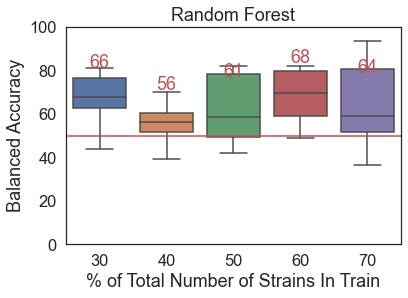

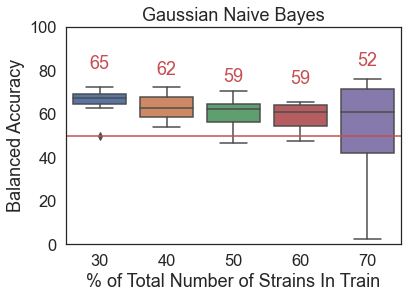

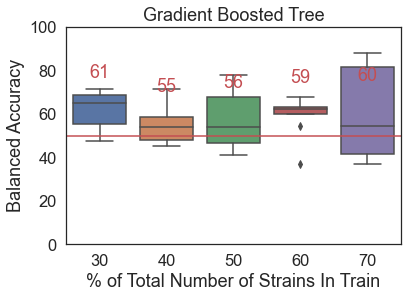

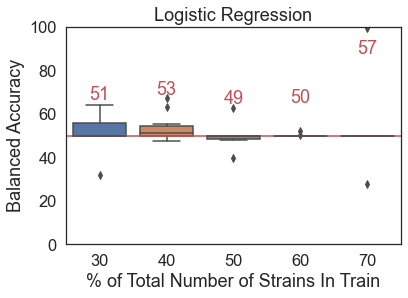

In [12]:
get_max_accuracy('tox_no_cdc1', th_path)
plot_leaderboard('tox_no_cdc1', th_path, print_acc = True)

# Test using the toxicity features + the SBRL features (no embedding)

In [13]:
cdc_features = pd.read_csv(prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/processed_cdc_data.csv', index_col = 0)

In [14]:
scaler = MinMaxScaler()
cdc_features['instance_sum'] = scaler.fit_transform(
        cdc_features['instance_sum'].values.reshape(len(cdc_features),1))

In [15]:
joined_tox_w_cdc1 = pd.merge(joined_toxicity, cdc_features, left_on = 'genus_species', right_index = True)
joined_tox_w_cdc1.Foe = joined_tox_w_cdc1.Foe.astype(int)

In [16]:
no_emb_path = prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/toxicity/btox_w_cdc_Sep21'
w_cdc_feature_cols = feature_cols1 + cdc_features.columns.to_list()
joined_tox_w_cdc1['index_col'] = range(len(joined_tox_w_cdc1))

In [57]:
run_ml(joined_tox_w_cdc1, 'tox_cdc_no_emb1',feature_cols_to_use=w_cdc_feature_cols, 
       models_to_test = [logistic_classifier, gaussian_naive_bayes_classification, random_forest_classification, gradient_boosted_tree],
       output_dir = no_emb_path, repeat = 10, 
       feature_cols_to_normalize=w_cdc_feature_cols, sparse_cols_to_use=None, percents = [0.3,0.4,0.5,0.6,0.7])


----------------------------------------------------------------------------------------------------
Starting run of model logistic_classifier at time 19:07:49
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.00 seconds
Testing time was: 0.01 seconds
Run finished at 19:07:49. Total run time = 0.81 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gaussian_naive_bayes_classification at time 19:07:50
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.01 seconds
Testing time was: 0.01 seconds
Run finished at 19:07:50. Total run time = 0.25 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


-------------------------------------------------------------

Description           Model Name                  
tox_cdc_no_emb1__0.7  random_forest_classification    62.9
Name: Balanced Accuracy, dtype: float64


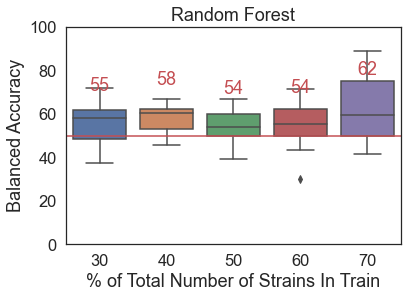

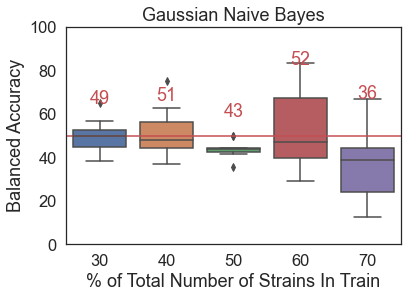

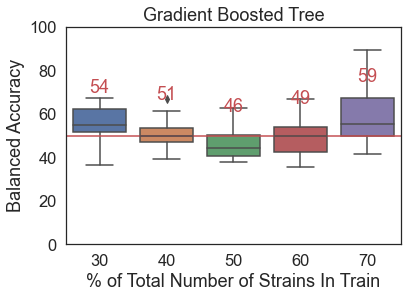

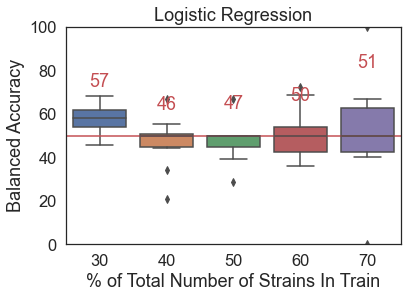

In [20]:
get_max_accuracy('tox_cdc_no_emb1', no_emb_path)
plot_leaderboard('tox_cdc_no_emb1', no_emb_path, print_acc = True)

# Test using the toxicity features + the SBRL embedding

In [21]:
feature_cols3 = feature_cols1 + post_train_mean.columns.tolist()

In [118]:
run_ml(tox_w_cdc_emb2, 'tox_w_cdc2',feature_cols_to_use=feature_cols3, 
       models_to_test = [logistic_classifier, gaussian_naive_bayes_classification, random_forest_classification, gradient_boosted_tree],
       output_dir = th_path, repeat = 10, 
       feature_cols_to_normalize=feature_cols3, sparse_cols_to_use=None, percents = [0.3,0.4,0.5,0.6,0.7])


----------------------------------------------------------------------------------------------------
Starting run of model logistic_classifier at time 14:15:18
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.00 seconds
Testing time was: 0.01 seconds
Run finished at 14:15:18. Total run time = 0.53 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gaussian_naive_bayes_classification at time 14:15:18
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.00 seconds
Testing time was: 0.01 seconds
Run finished at 14:15:19. Total run time = 0.49 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


-------------------------------------------------------------

Description              Model Name         
tox_w_cdc2_6to15h1__0.3  logistic_classifier    64.2
Name: Balanced Accuracy, dtype: float64


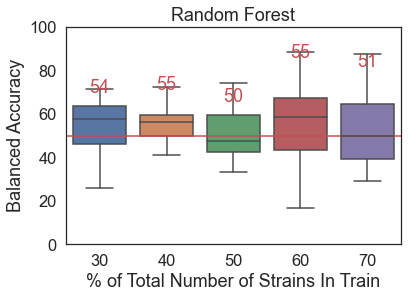

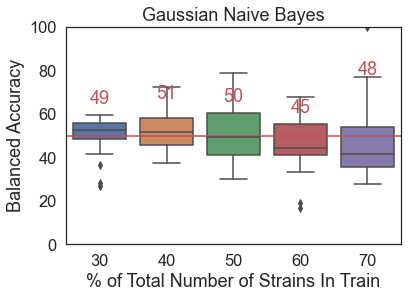

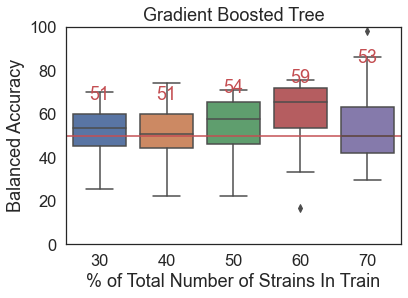

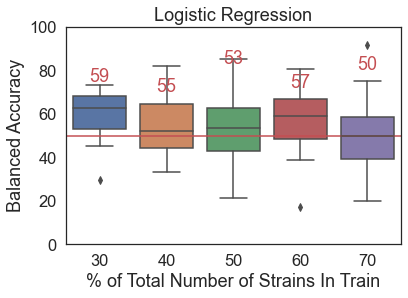

In [23]:
get_max_accuracy('tox_w_cdc2', th_path)
plot_leaderboard('tox_w_cdc2', th_path, print_acc = True)

# Deep dive: why did toxicity performance decrease by including the SBRL features/ embedding?

## Look at the test data with no SBRL data

In [24]:
def add_pred_type(test_df):
    test_df_copy = test_df.copy()
    test_df_copy['pred_type'] = '- as -'
    test_df_copy.loc[(test_df.Foe == 0) & (test_df_copy['Foe_predictions'] == 1), 'pred_type'] = '- as +'
    test_df_copy.loc[(test_df.Foe == 1) & (test_df_copy['Foe_predictions'] == 0), 'pred_type'] = '+ as -'
    test_df_copy.loc[(test_df.Foe == 1) & (test_df_copy['Foe_predictions'] == 1), 'pred_type'] = '+ as +'
    return test_df_copy

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [26]:
th_path = prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/toxicity/tox_w_cdc_Apr16'
tox_test_df = get_test_data('tox_no_cdc1', 0.6, 'random', th_path)
tox_test_w_features = pd.merge(tox_test_df, tox_w_cdc_emb[['index_col','Time','DAPI','Hoechst']], on = 'index_col')
tox_test_w_features['scaled_DAPI'] = scaler.fit_transform(tox_test_w_features['DAPI'].values.reshape(-1,1))

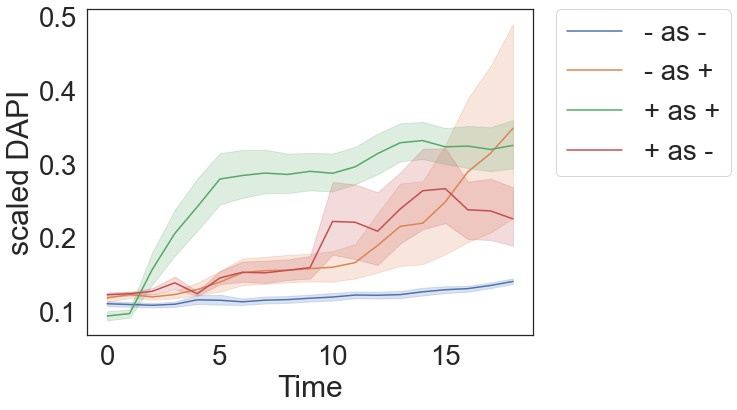

In [35]:
tox_test_w_features=add_pred_type(tox_test_w_features)
sns.set(rc={'figure.figsize': (8, 6)}, font_scale=2.5)
sns.set_style('white')
sns.lineplot('Time', 'scaled_DAPI', data = tox_test_w_features, hue = 'pred_type')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('scaled DAPI');

## Look at the test data with SBRL features

In [29]:
from sklearn.decomposition import PCA
pca = PCA(n_components= 1)

In [30]:
no_emb_path = prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/toxicity/tox_w_cdc_Sep21'
tox_sbrl_test_df = get_test_data('tox_cdc_no_emb1', 0.7, 'random', no_emb_path)
ft_to_use = ['index_col','Time','DAPI','Hoechst'] + cdc_features.columns.to_list()
tox_sbrl_test_w_features = pd.merge(tox_sbrl_test_df, joined_tox_w_cdc1[ft_to_use], on = 'index_col')
tox_sbrl_test_w_features['scaled_DAPI'] = scaler.fit_transform(tox_sbrl_test_w_features['DAPI'].values.reshape(-1,1))
ft_to_use2 = ['scaled_DAPI'] + cdc_features.columns.to_list()
tox_sbrl_test_w_features['ft_pc'] = pca.fit_transform(tox_sbrl_test_w_features[ft_to_use2])

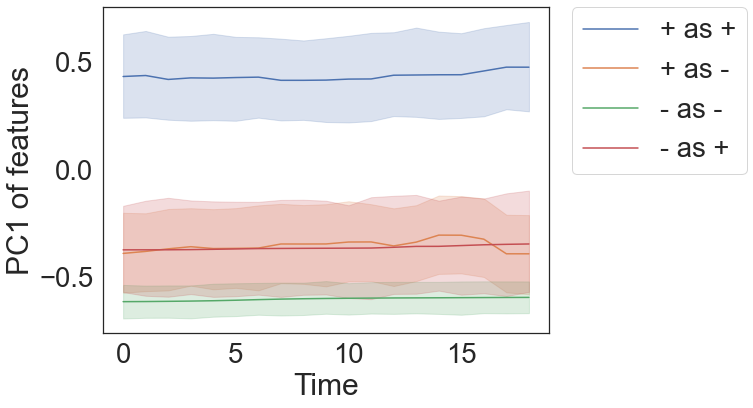

In [31]:
tox_sbrl_test_w_features=add_pred_type(tox_sbrl_test_w_features)
sns.lineplot('Time', 'ft_pc', data = tox_sbrl_test_w_features, hue = 'pred_type')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('PC1 of features');

## Look at the test data with SBRL embedding (fingerprints)

In [43]:
tox_sbrl_emb_test = get_test_data('tox_w_cdc2', 0.3, 'logistic', th_path)
ft_to_use3 = ['index_col','Time','DAPI','Hoechst'] + post_train_mean2.columns.to_list()
tox_sbrl_emb_w_features = pd.merge(tox_sbrl_emb_test, tox_w_cdc_emb2[ft_to_use3], on = 'index_col')

In [44]:
tox_sbrl_emb_w_features['scaled_DAPI'] = scaler.fit_transform(tox_sbrl_emb_w_features['DAPI'].values.reshape(-1,1))
ft_to_reduce = ['scaled_DAPI'] + post_train_mean2.columns.to_list()
tox_sbrl_emb_w_features['ft_pc'] = pca.fit_transform(tox_sbrl_emb_w_features[ft_to_reduce])

In [45]:
tox_sbrl_emb_w_features=add_pred_type(tox_sbrl_emb_w_features)

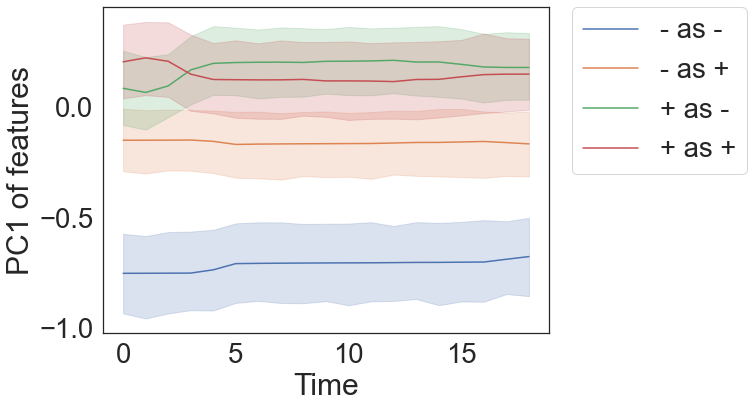

In [46]:
sns.set(rc={'figure.figsize': (8, 6)}, font_scale=2.5)
sns.set_style('white')
sns.lineplot('Time', 'ft_pc', data = tox_sbrl_emb_w_features, hue = 'pred_type')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('PC1 of features');